## Global Ocean Diagnostics

#### PATH to import function


In [1]:
import os
# print(os.getcwd())

os.chdir("..")
print(os.getcwd())

/home/b/b382119/AQUA/diagnostics/ocean3d


### Import Modules

In [2]:
%load_ext autoreload
%autoreload 2
from aqua import Reader,catalogue, inspect_catalogue
from ocean_drifts import hovmoller_lev_time_plot
from ocean_drifts import time_series_multilevs
from ocean_drifts import multilevel_t_s_trend_plot
from ocean_drifts import zonal_mean_trend_plot
from aqua.util import load_yaml

### Import Data

In [35]:
# Here we read one of the reference NextGEMS Cycle 3 simulations
reader = Reader(model='FESOM', exp='tco2559-ng5-cycle3', source="lra-r100-monthly")

# And we extract the Potential Temperature and Practical Salinity fields, resampling in yearly means
# Yearly means are more adequate to identify drifts as they are not contaminated by seasonal cycle signals
yearly_data = reader.retrieve()[["ocpt","so"]].resample(time="YS").mean()
yearly_data=yearly_data.rename({"nz1":"lev"})

### Functions:
All functions (primary and secondary) can be found in global_ocean

The four main diagnostic functions are:
1. ##### hovmoller_lev_time_plot

hovmoller_lev_time_plot(data, region, type= None , latS: float=None, latN: float=None, lonW: float=None, lonE: float=None, output= False, output_dir=  output_dir)

This function produces hovmollers in depth and time of yearly potential ocean temperature and practical salinity spatially averaged over a predefined ocean region or a customised lat-lon box. Its intended to be used only with model data goal and its goal is to help identify potential drifts at different ocean levels.

It requires you to provide: 
- A file with model data of 3D ocean potential temperature and practical salinity
- The specific region over which the spatial average is computed (or to provide a custom latxlon box instead)
- A choice on how to preprocess the data, to choose between
    - FullValue: The full values of the respective variables
    - Anomaly_t0: Anomalies computed against the first year
    - Anomaly_tmean: Anomalies computed agains the temporal mean of the whole period
    - StdAnomaly_t0: Standardised version of Anomaly_t0 (using the standard deviation of the whole period) 
    - StdAnomaly_tmean: Standardised version of Anomaly_tmean (using the standard deviation of the whole period) 


2. ##### time_series_multilevs
time_series_multilevs(data, region=None, type = None, customise_level=False, levels=None, latS: float=None, latN: float=None, lonW: float=None, lonE: float=None,  output= True, output_dir =  output_dir)

This function produces timeseries of yearly potential ocean temperature and practical salinity spatially averaged over a predefined ocean region or a customised lat-lon box for a set of selected levels. Its intended to be used only with model data goal and its goal is to help identify potential drifts at different ocean levels.

It requires you to provide: 
- A file with model data of 3D ocean potential temperature and practical salinity
- The specific region over which the spatial average is computed (or to provide a custom latxlon box instead)
- The choice on how to preprocess the data, to choose between
    - FullValue: The full values of the respective variables
    - Anomaly_t0: Anomalies computed against the first year
    - Anomaly_tmean: Anomalies computed agains the temporal mean of the whole period
    - StdAnomaly_t0: Standardised version of Anomaly_t0 (using the standard deviation of the whole period) 
    - StdAnomaly_tmean: Standardised version of Anomaly_tmean (using the standard deviation of the whole period) 
- The choice on the vertical levels to include in the plot (by default: 0, 100, 500, 1000, 2000, 3000, 4000, 5000)


3. ##### multilevel_t_s_trend_plot
multilevel_t_s_trend_plot(data, region=None, customise_level=False, levels=None, latS: float=None, latN: float=None, lonW: float=None, lonE: float=None,  output= True, output_dir =  output_dir)

This function produces plots with the linear trends in time at the grid point levels for a set of selected levels. It helps to identify the areas and depths where the stronger trends (and potential drifts) are developping.

It requires you to provide: 
- A file with model data of 3D ocean potential temperature and practical salinity
- The specific region to be shown in the plots
- The choice on the vertical levels to include in the plot (by default: 10, 100, 500, 1000, 3000, 5000)

4. ##### zonal_mean_trend_plot
zonal_mean_trend_plot(data, region=None, latS: float=None, latN: float=None, lonW: float=None, lonE: float=None,  output= True, output_dir =  output_dir):

This function produces plots of zonally averaged linear trends in time as a function of depth and latitude over a selected region. It helps to identify the latitudes and depths where the stronger trends (and potential drifts) are developping.

It requires you to provide: 
- A file with model data of 3D ocean potential temperature and practical salinity
- The specific region over which the zonal averages are computed and shown


In [31]:
config = load_yaml("config.yaml")
hovmoller_config= config["hovmoller_lev_time_plot"]
time_series_config= config["time_series_multilevs"]
multilevel_trend_config= config["multilevel_trend"]

print(hovmoller_config)
print(time_series_config)
print(multilevel_trend_config)


{'region': 'Global Ocean', 'latS': None, 'latN': None, 'lonE': None, 'lonW': None, 'type': 'FUllvalue', 'output': True, 'output_dir': './output'}
{'region': 'Global Ocean', 'latS': None, 'latN': None, 'lonE': None, 'lonW': None, 'type': 'anomally', 'customise_level': None, 'levels': None, 'output': True, 'output_dir': './output'}
{'region': 'Global Ocean', 'latS': None, 'latN': None, 'lonE': None, 'lonW': None, 'output': True, 'output_dir': './output'}


In [13]:
output_dir = "~/aqua_output"


'b382119'

2023-07-14 16:13:43,483 - INFO - Selected for this region (latitude -90.0 to 90.0, longitude 0.0 to 360.0)
2023-07-14 16:13:43,509 - INFO - Data processed for fullvalue
2023-07-14 16:13:43,510 - INFO - Hovmoller plotting in process


2023-07-14 16:14:32,665 - INFO - Figure and data used for this plot are saved here: /home/b/b382119/aqua_output/hovmoller_plot_FullValue_global_ocean_mean_20230714_161343


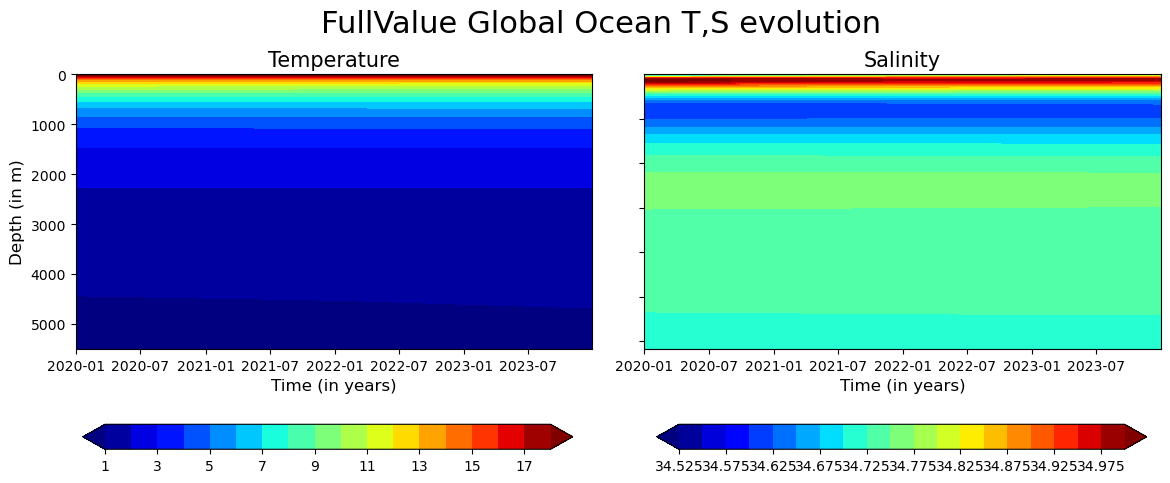

In [12]:
# This first example produces the hovmoller directly for the Full Values of Global Ocean temperature and salinity averages
#  Full Values are useful to visualise how the ocean is stratified but less so to identify drifts
hovmoller_lev_time_plot(yearly_data, region= "Global Ocean",type = 'FullValue', output= True, output_dir=  output_dir)


2023-07-14 16:26:18,652 - INFO - Selected for this region (latitude -90.0 to 90.0, longitude 0.0 to 360.0)
2023-07-14 16:26:18,692 - INFO - Data processed for anomaly_vs_tmean
2023-07-14 16:26:18,693 - INFO - Hovmoller plotting in process
2023-07-14 16:26:42,516 - INFO - Figure and data used for this plot are saved here: /home/b/b382119/aqua_output/hovmoller_plot_Anomaly_vs_Tmean_global_ocean_mean_20230714_162618


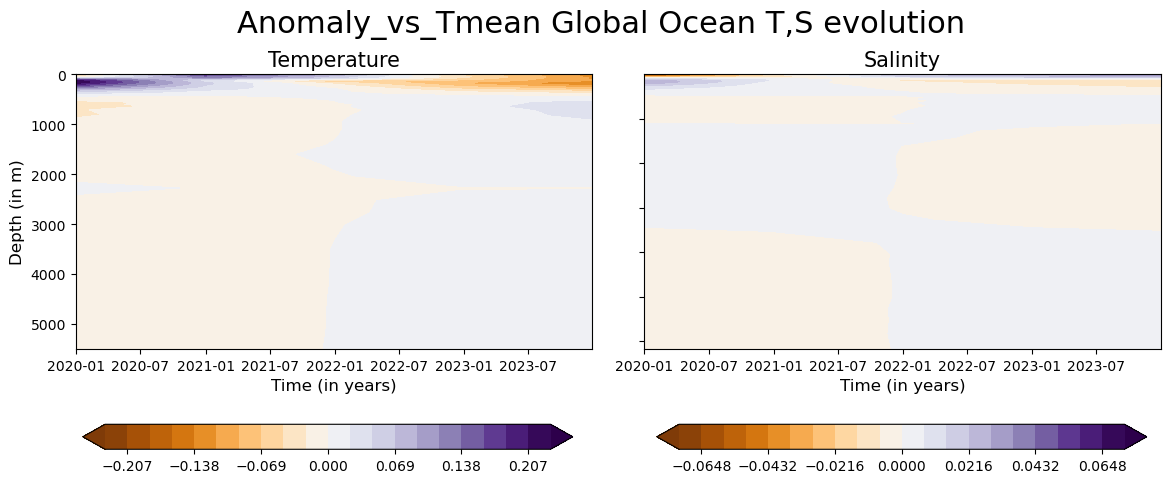

In [14]:
# This second example produces the associated anomalies referred to the temporal mean
#  Anomalies are useful to visualise how ocean anomalies (and drifts) manifest near the surface, but less so in the deep ocean
#  Anomalies referred to the full periood 
hovmoller_lev_time_plot(data = yearly_data, region= "Global Ocean",type = 'Anomaly_vs_Tmean', output= True, output_dir=  output_dir)


2023-07-14 16:26:43,115 - INFO - Selected for this region (latitude -90.0 to 90.0, longitude 0.0 to 360.0)
2023-07-14 16:26:43,158 - INFO - Data processed for stdanomaly_tmean
2023-07-14 16:26:43,158 - INFO - Hovmoller plotting in process


2023-07-14 16:26:59,301 - INFO - Figure and data used for this plot are saved here: /home/b/b382119/aqua_output/hovmoller_plot_stdanomaly_tmean_global_ocean_mean_20230714_162643


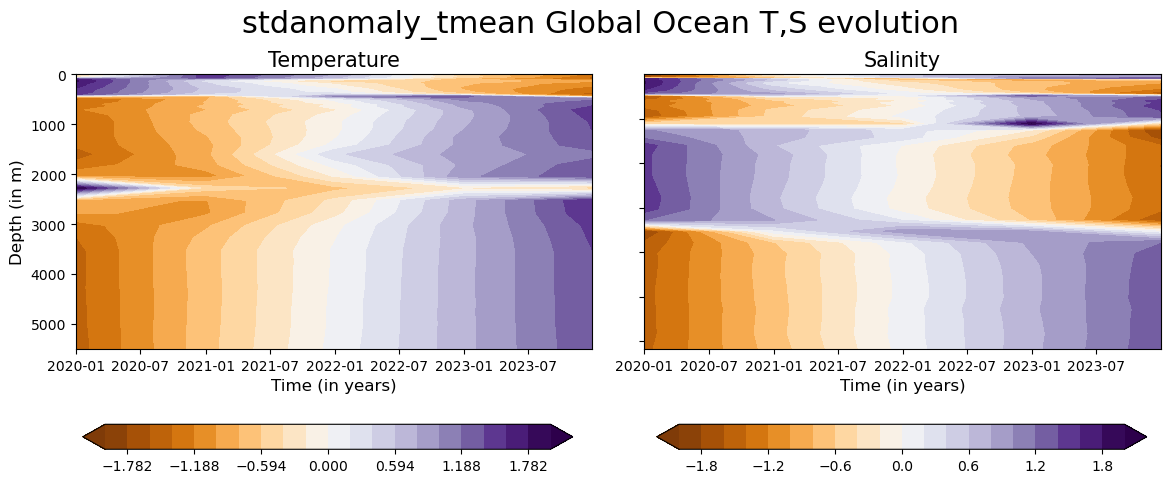

In [15]:
# The third example produces the associated standardised anomalies (referred to the temporal mean)
#  Standardised Anomalies are useful to visualise drifts at all ocean levels, but does not allow to compare their magnitude
#  Referring anomalies wrt the temporal mean allows to better visualise opposing trends and the inflection point
hovmoller_lev_time_plot(data = yearly_data, region= "Global Ocean",type = 'stdanomaly_tmean', output= True, output_dir=  output_dir)


2023-07-14 16:26:59,837 - INFO - Selected for this region (latitude -90.0 to 90.0, longitude 0.0 to 360.0)
2023-07-14 16:26:59,874 - INFO - Data processed for stdanomaly_t0
2023-07-14 16:26:59,875 - INFO - Hovmoller plotting in process
2023-07-14 16:27:16,581 - INFO - Figure and data used for this plot are saved here: /home/b/b382119/aqua_output/hovmoller_plot_stdanomaly_t0_global_ocean_mean_20230714_162659


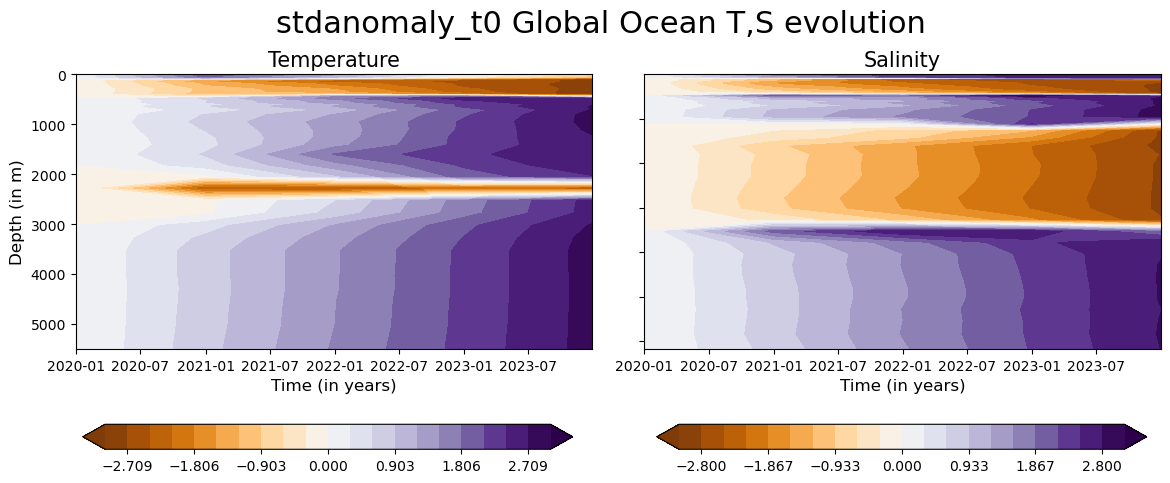

In [16]:
# The fourth example produces global standardised anomalies but referred to the first temporal step
#  Standardised Anomalies are useful to visualise drifts at all ocean levels, but does not allow to compare their magnitude
#  Referring the anomalies wrt to the first year allows to see which layers get colder and which ones warmer in time

hovmoller_lev_time_plot(data = yearly_data, region= "Global Ocean",type = 'stdanomaly_t0', output= True, output_dir=  output_dir)


2023-07-14 16:27:17,175 - INFO - Selected for this region (latitude -90.0 to 90.0, longitude 0.0 to 360.0)


2023-07-14 16:27:17,208 - INFO - Data processed for fullvalue
2023-07-14 16:27:17,209 - INFO - Time series plot is in process
2023-07-14 16:27:54,216 - INFO -  Figure and data used in the plot, saved here : /home/b/b382119/aqua_output/time_series_FullValue_global_ocean_mean_20230714_162750


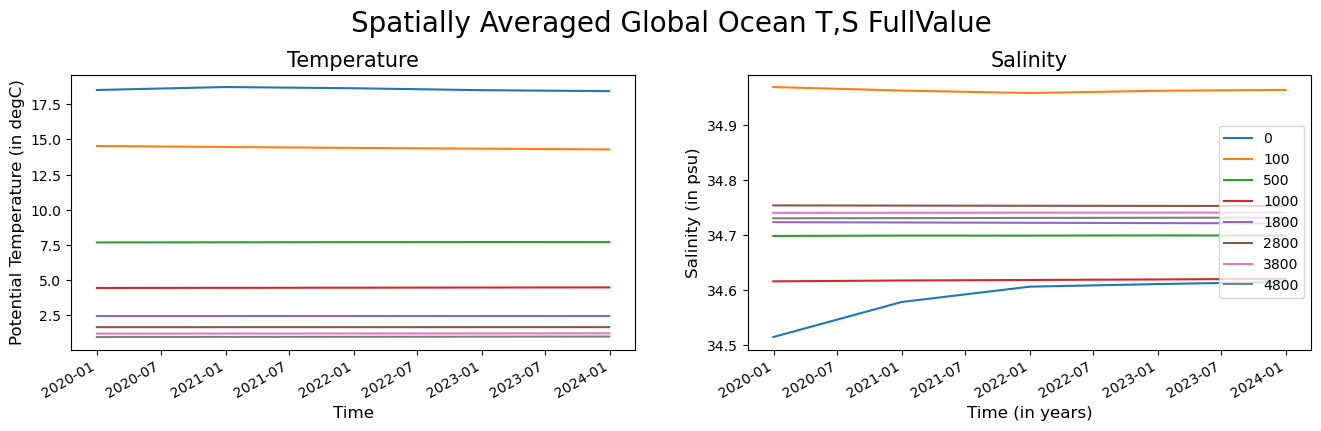

In [17]:
# This example is for the function that plots timeseries of Globally averaged yearly full values of ocpt and so 
#  at the default depth levels
time_series_multilevs(yearly_data,'Global Ocean', type="FullValue",customise_level=False, levels=list,output = True,  output_dir= output_dir)

2023-07-14 16:27:54,839 - INFO - Selected for this region (latitude -90.0 to 90.0, longitude 0.0 to 360.0)
2023-07-14 16:27:54,875 - INFO - Data processed for anomaly_t0
2023-07-14 16:27:54,876 - INFO - Time series plot is in process


2023-07-14 16:28:36,185 - INFO -  Figure and data used in the plot, saved here : /home/b/b382119/aqua_output/time_series_Anomaly_t0_global_ocean_mean_20230714_162831


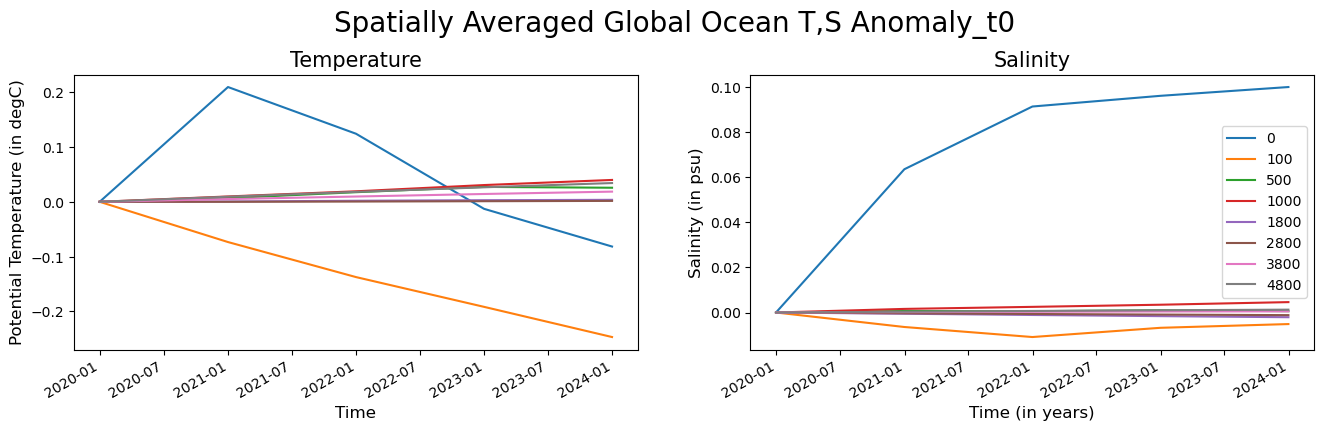

In [18]:
# This example is for the function that plots timeseries of Globally averaged yearly anomalies (wrt t0) of ocpt and so 
# at the default depth levels
time_series_multilevs(yearly_data,'Global Ocean', type="Anomaly_t0",customise_level=False, levels=list,output = True,  output_dir= output_dir)

2023-07-14 16:45:05,127 - INFO - Selected for this region (latitude -90.0 to 90.0, longitude 0.0 to 360.0)
2023-07-14 16:45:05,164 - INFO - Data processed for std_anomaly_vs_t0
2023-07-14 16:45:05,165 - INFO - Time series plot is in process
2023-07-14 16:45:53,694 - INFO -  Figure and data used in the plot, saved here : /home/b/b382119/aqua_output/time_series_Std_Anomaly_vs_t0_global_ocean_mean_20230714_164549


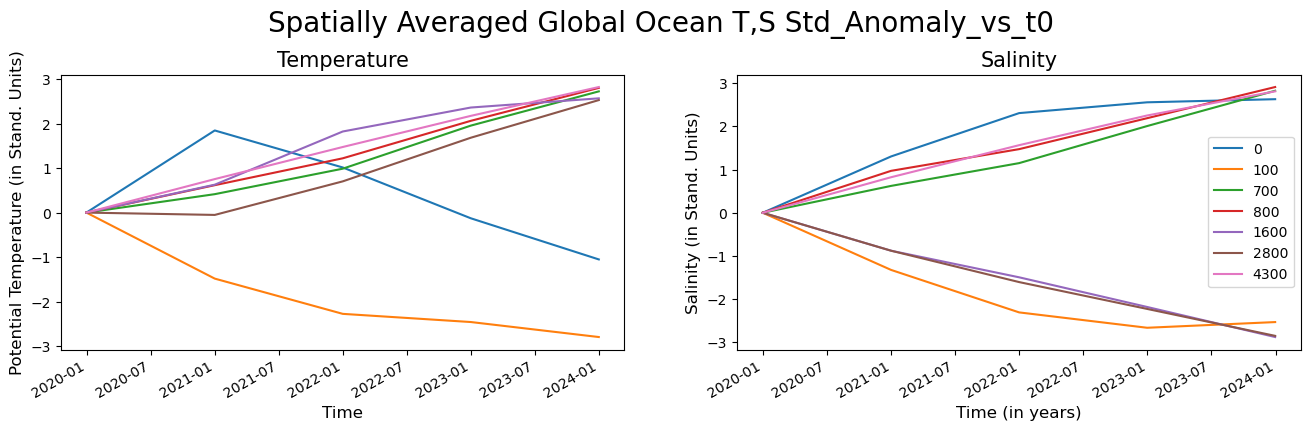

In [32]:
# This example is for the function that plots timeseries of Globally averaged standardised yearly anomalies (wrt t0) 
# of ocpt and so for a customised selection of depth levels

time_series_multilevs(yearly_data,'Global Ocean', type="Std_Anomaly_vs_t0",customise_level=True, levels=[50, 150, 750, 900, 1600, 3000, 4500], output = True,  output_dir= output_dir)

2023-07-14 16:29:11,577 - INFO - Selected for this region (latitude -90.0 to 90.0, longitude 0.0 to 360.0)


2023-07-14 16:29:30,267 - INFO - Trend value calculated
2023-07-14 16:29:33,447 - INFO - Figure and data used for this plot are saved here: /home/b/b382119/aqua_output/multilevel_t_s_trend___global_ocean_mean_20230714_162931


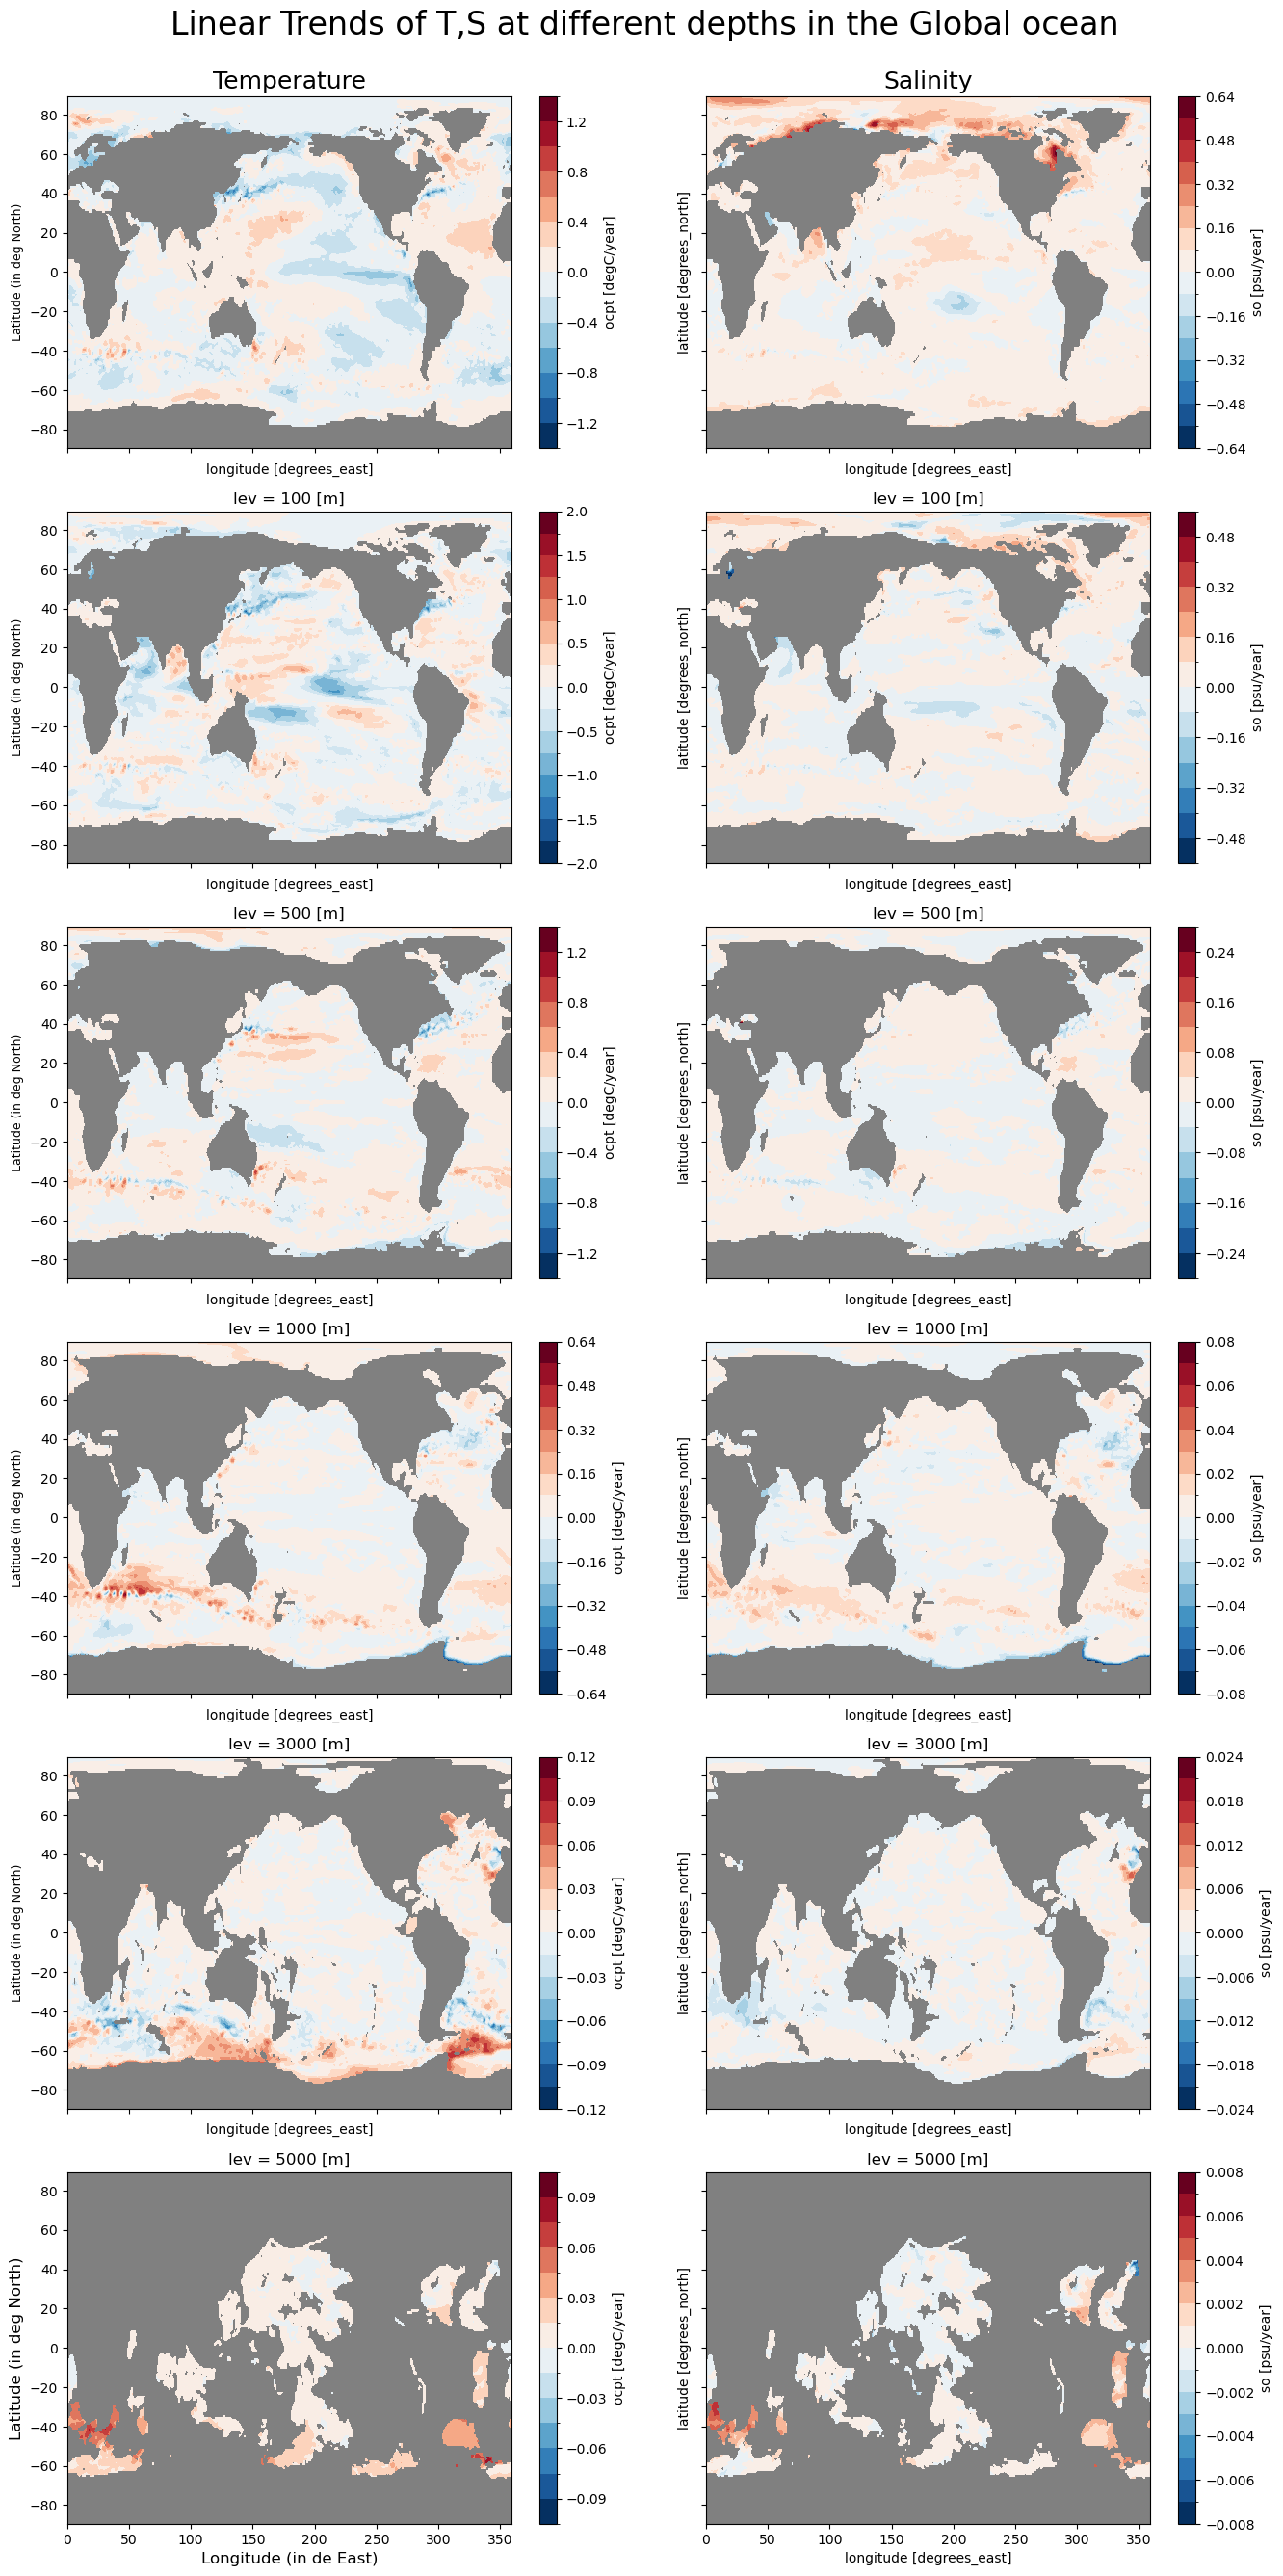

In [20]:
# This is an example  for the function that plots maps of temporal trends (computed for all years in the dataset) 
#  and plots them for the whole Global Ocean for the default list of vertical levels
multilevel_t_s_trend_plot(yearly_data,'Global Ocean', customise_level=False, levels=None,output= True, output_dir =  output_dir)


2023-07-14 16:29:35,648 - INFO - Selected for this region (latitude -30.0 to 30.0, longitude 30 to 110.0)


2023-07-14 16:29:52,799 - INFO - Trend value calculated
2023-07-14 16:29:54,682 - INFO - Figure and data used for this plot are saved here: /home/b/b382119/aqua_output/multilevel_t_s_trend___indian_ocean_mean_20230714_162953


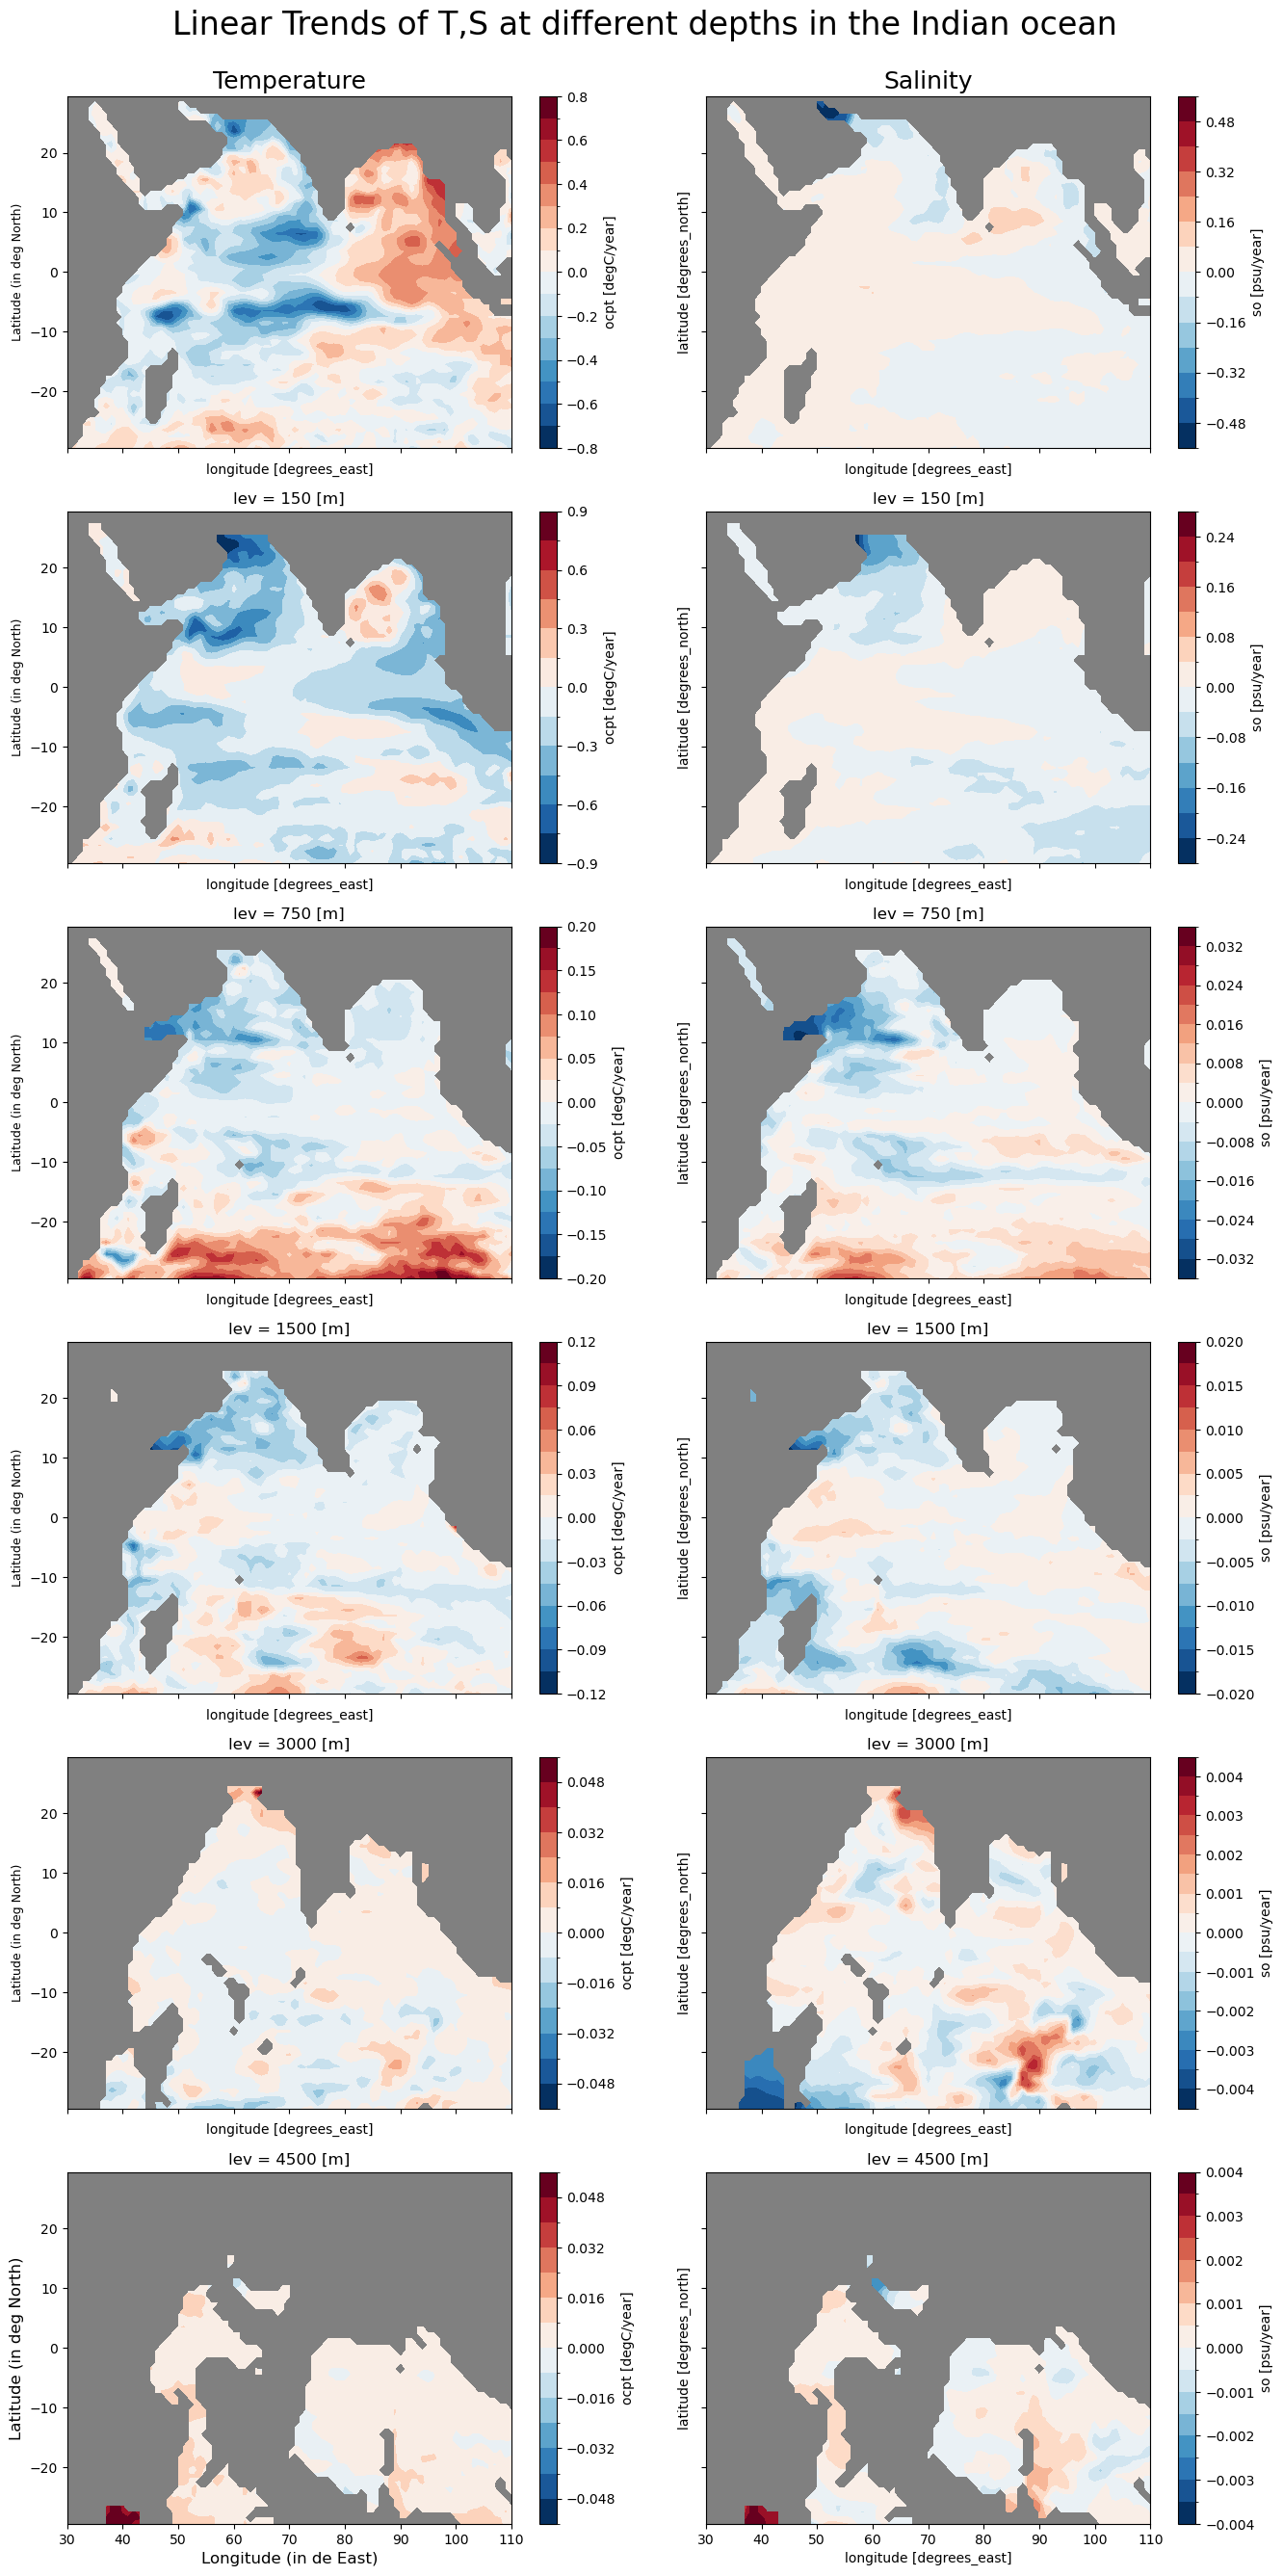

In [21]:
# This is another example for the function that plots maps of temporal trends (computed for all years in the dataset) 
#  cropped now to the Atlantic Ocean and shown for a customised list of levels
multilevel_t_s_trend_plot(yearly_data,'indian Ocean', customise_level=True, levels=[50, 150, 750, 1500, 3000, 4500], output= True, output_dir =  output_dir)


2023-07-14 16:30:16,699 - INFO - Trend value calculated
2023-07-14 16:30:16,701 - INFO - Selected for this region (latitude -30.0 to 30.0, longitude 30 to 110.0)
2023-07-14 16:30:17,033 - INFO - Figure and data used for this plot are saved here: /home/b/b382119/aqua_output/zonal_mean_trend___indian_ocean__mean_20230714_163016


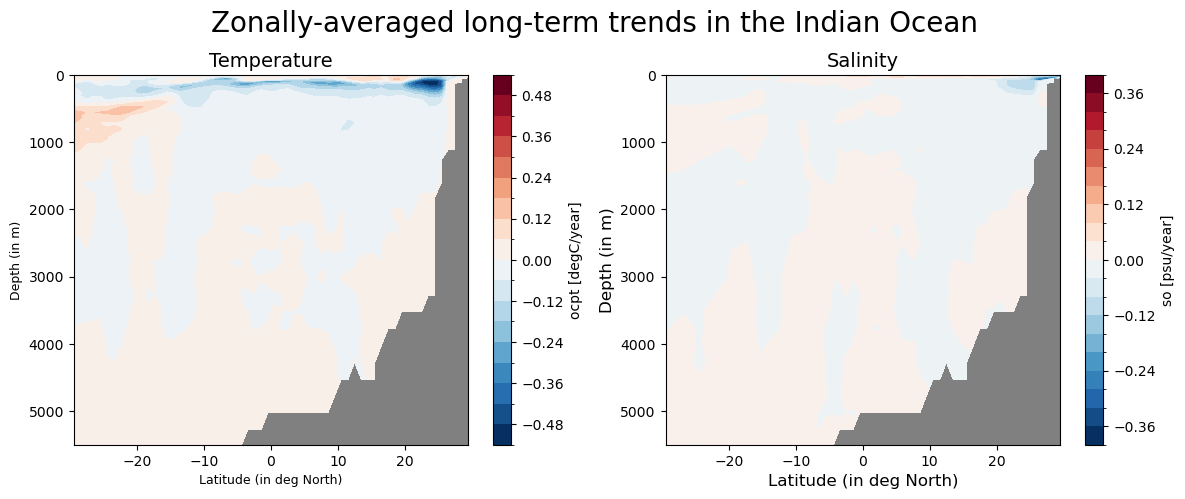

In [22]:
# This is an example for the function that plots zonally averaged linear trends of T, S as a function of depth and latitude
#  in this case for the Indian Ocean
zonal_mean_trend_plot(yearly_data, region= "Indian Ocean ", output= True, output_dir= output_dir)

2023-07-14 16:30:38,241 - INFO - Trend value calculated
2023-07-14 16:30:38,243 - INFO - Selected for this region (latitude -90.0 to 90.0, longitude 0.0 to 360.0)
2023-07-14 16:30:38,627 - INFO - Figure and data used for this plot are saved here: /home/b/b382119/aqua_output/zonal_mean_trend___global_ocean__mean_20230714_163038


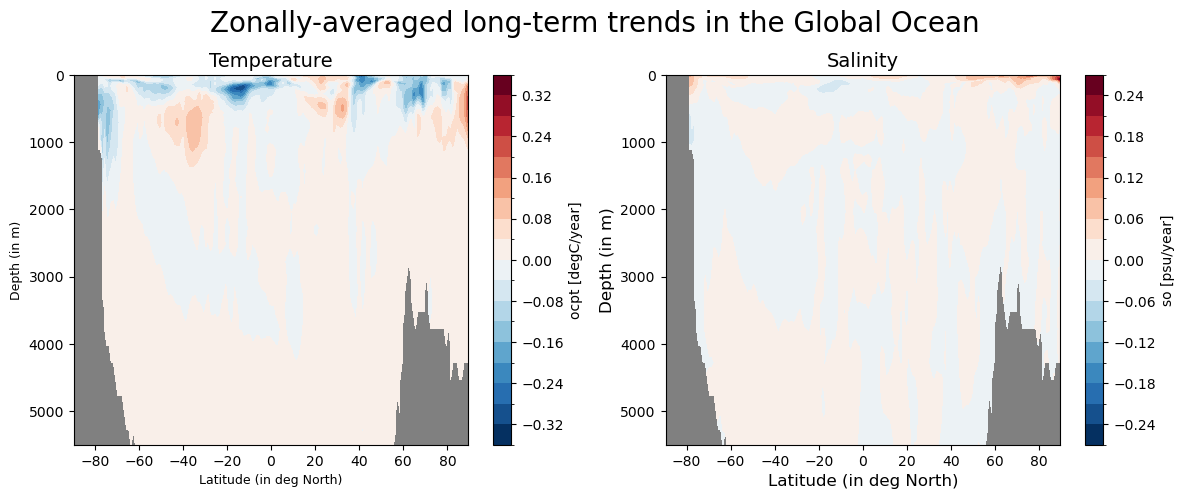

In [23]:
# This is an example for the function that plots zonally averaged linear trends of T, S as a function of depth and latitude
#  in this case for the Global Ocean
zonal_mean_trend_plot(yearly_data, region= "Global Ocean ", output= True, output_dir= output_dir)